In [1]:
from utils_synthetic import *
from scipy.special import binom as spb
from matplotlib import cm
%load_ext autoreload
%autoreload 2
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [2]:
def prediction_strength(data, method_dict):
    
    train_set, test_set = random_splitting(data, 0.5)
    true_labels, predicted_labels = fit_clustering(train_set, test_set, method_dict)
    
    # co-clustering occurrences
    overlap_size = np.zeros(len(np.unique(true_labels)))
    for c, class_label in enumerate(np.unique(true_labels)): # true test set labels
        overlap = 0
        count = 0
        idx_true = np.where(true_labels == class_label)[0]
        
        for ii, i in enumerate(idx_true):
            for jj, j in enumerate(idx_true[ii:]):
                overlap += predicted_labels[i] == predicted_labels[j]
                count+=1
        overlap_size[c] = overlap/count
    #print(overlap_size)
    return min(overlap_size)
        

def igp(data, method_dict):
    
    true_labels, predicted_labels = fit_clustering(data, data, method_dict) # test set labels and predicted labels
    igp_score = np.zeros(len(np.unique(true_labels))) # empty vector for scores
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data) # find nearest neighbors
    distances, nearest_neighbor_idx = nbrs.kneighbors(data)
 
    for c, class_label in enumerate(np.unique(true_labels)): # true test set labels
        
        idx_true = np.where(true_labels == class_label)[0]
        overlap = [true_labels[i] == true_labels[nearest_neighbor_idx[i,1]] for i in idx_true]
        igp_score[c] = np.sum(overlap)/len(overlap)
        
    return igp_score, true_labels

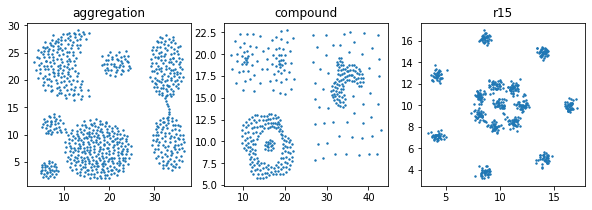

In [3]:
INIT = 'k-means++'
N_INIT = 50
MAX_ITER = 300

aggregation = np.loadtxt('Data/Shapes/aggregation.txt')
compound = np.loadtxt('Data/Shapes/compound.txt')
r15 = np.loadtxt('Data/Shapes/r15.txt')


shapes_datasets = {}
shapes_datasets['aggregation'] = aggregation
shapes_datasets['compound'] = compound
shapes_datasets['r15'] = r15

plt.figure(figsize = (10,3))
for d, ds in enumerate(shapes_datasets):
    plt.subplot(1,len(shapes_datasets), d+1)
    plt.title(ds)
    plt.scatter(shapes_datasets[ds][:,0], shapes_datasets[ds][:,1], s= 2)
plt.show()

In [ ]:
c_ls = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'gray']
clus_ls = [2,3,4,5,10,14, 15, 16,17,20]
dataset_names = ['aggregation', 'compound', 'r15']
n_cols = len(clus_ls)
results = {}
for _, dataset in enumerate([aggregation, compound, r15]):
    k_=0 # PLOT COUNTER
    dataset_ = dataset_names[_]
    results[dataset_] = {}
    results[dataset_]['prediction_strength'] = np.zeros(20)
    results[dataset_]['IGP'] = {}
    
    plt.figure(figsize = (24,6))
    for k in np.arange(1,21):
        
        default_dict_ = default_dictionary_kmeans(k, INIT, N_INIT, MAX_ITER)
        
        results[dataset_]['prediction_strength'][k-1] = prediction_strength(dataset, default_dict_)
        
        results[dataset_]['IGP'][k] = {}
        igp_scores, labs = igp(dataset, default_dict_)
        results[dataset_]['IGP'][k]['labels'] = labs
        results[dataset_]['IGP'][k]['IGP_scores'] = igp_scores

        
        if k in clus_ls:
                        
            c_ls = cm.gist_ncar(np.linspace(.25, .9, k))

            plt.subplot(2,len(clus_ls),k_+1)



            colors = [c_ls[label] for label in labs]
            
            
            plt.scatter(dataset[:,0], dataset[:,1], color = colors, s=2)
            plt.title(r'$k=$'+str(k), fontsize = 20)
            plt.subplot(2,len(clus_ls),len(clus_ls)+k_+1)

            if k_ == 0:
                plt.ylabel('IGP scores', fontsize = 15)
            for _ in range(len(np.unique(labs))):

                plt.scatter(x = _+1, y = igp_scores[_], color = c_ls[_])
                plt.vlines(x = _+1, ymin = 0, ymax = igp_scores[_], color = c_ls[_])
            plt.ylim([0,1.05])
            plt.xlabel('Cluster index', fontsize = 20)
            k_+=1
            
    plt.tight_layout()
    plt.savefig('Plots/IGP_'+str(dataset_)+'.pdf', bbox_inches = 'tight')
    plt.show()
        
# np.save('Additional_Experiments/prediction_test.npy', results)

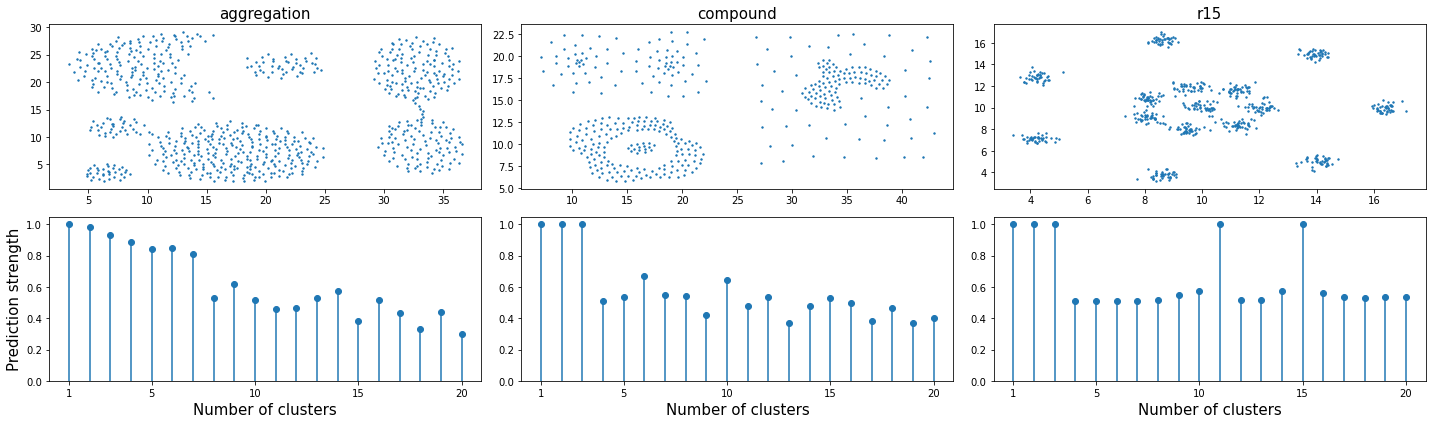

In [4]:
results = np.load('Additional_Experiments/prediction_test.npy', allow_pickle=1).item()
dataset_names = ['aggregation', 'compound', 'r15']
plt.figure(figsize = (20,6))
for d, dataset in enumerate([aggregation, compound, r15]):
    dataset_name = dataset_names[d]
    plt.subplot(2,3,d+1)
    plt.scatter(dataset[:,0], dataset[:,1], s=2)
    plt.title(dataset_name, fontsize = 15)
    
    plt.subplot(2,3,d+1+3)
    plt.scatter(np.arange(1,21), results[dataset_name]['prediction_strength'])
    for _ in range(20):
        plt.vlines(x=_+1, ymin = 0, ymax = results[dataset_name]['prediction_strength'][_])
    if d == 0:
        plt.ylabel('Prediction strength', fontsize = 15)
    plt.xlabel('Number of clusters', fontsize = 15)
    plt.xticks([1,5,10,15,20])
    plt.ylim([0,1.05])
    
plt.tight_layout()
# plt.savefig('Plots/prediction_strength.pdf', dpi = 1000, bbox_inches = 'tight')
plt.show()